In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import ChatOllama
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import END, MessageGraph
from IPython.display import Image, display, clear_output
from langchain.globals import set_verbose
set_verbose(True)

In [11]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a helpful assistant that generates commonly asked MCQ questions
            on the GMAT quant exam. Generate an MCQ with four options when prompted to 
            do so. Do not generate questions, with more than 1 correct answers.
            If the user ever responds with 'RIGHT', it means the question you 
            generated has a valid solution in the options you provided.
            
            If the user responds with 'WRONG', the question you generated does not have
            a valid solution in the options. In both cases, respond by generating a new
            question without any other commentary. 
            
            Response: <'Question with 4 options'>
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [12]:

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are an expert in mathematics tasked with solving an MCQ commonly asked
            on the GMAT quant exam. When provided with a question 
            you should solve it step by step to reach the answer. If the answer you calculated 
            matches with one of the provided choices with the question exactly, respond 
            with 'RIGHT' otherwise you must respond with 'WRONG' to indicate that the provided
            choices do not contain the answer to the question. You should respond strictly in 
            the following JSON format.
            
            {{Response: <'RIGHT' if your answer is one of the choices 'WRONG' otherwise>
              Solution: <the detailed solution>,
              }} 
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)



# chat1 = ChatOllama(model='llama3.2:3b', temperature=1)
# chat2 = ChatOllama(model='llama3.2:3b', temperature=0.5)
# generate_chain = generation_prompt | chat1
# reflect_chain = reflection_prompt | chat2
chat = ChatOllama(model='llama3.2:3b')
generate_chain = generation_prompt | chat
reflect_chain = reflection_prompt | chat

##### Set up the graph

In [13]:
REFLECT = "reflect"
GENERATE = "generate"


def generation_node(state: Sequence[BaseMessage]):
    res = generate_chain.invoke({"messages": state})
    return res


def reflection_node(state: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Don't need all history - the last generated AIMessage only
    inverted = [HumanMessage(content=state[-1].content)]
    res = reflect_chain.invoke({"messages": inverted})
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node(GENERATE, generation_node)
builder.add_node(REFLECT, reflection_node)
builder.set_entry_point(GENERATE)

In [14]:
def should_continue(state: List[BaseMessage]):
    #if ('RIGHT' in state[-2].content.upper()) and (len(state)>6):
    if len(state) > 20:
        return END
    return REFLECT

In [15]:
builder.add_conditional_edges(GENERATE, should_continue)
builder.add_edge(REFLECT, GENERATE)

In [16]:
graph = builder.compile()


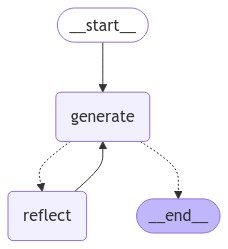

In [17]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
human = HumanMessage(content='Generate a new question')
response = graph.invoke(human)
response


[HumanMessage(content='Generate a new question', additional_kwargs={}, response_metadata={}, id='64bd51d3-4d42-447a-a9b0-be5399b3e1a2'),
 AIMessage(content='What is the value of x in the equation: 2x + 5 = 11? \n\nA) 2\nB) 3\nC) 1\nD) 4', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-11-14T21:41:27.904234Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 8367633500, 'load_duration': 2832607200, 'prompt_eval_count': 164, 'prompt_eval_duration': 3031889000, 'eval_count': 41, 'eval_duration': 2494542000}, id='run-0dce5ebc-16d5-466d-8b8c-aa8adf16f1d0-0', usage_metadata={'input_tokens': 164, 'output_tokens': 41, 'total_tokens': 205}),
 HumanMessage(content='{Response: B,\n Solution:\n To solve for x, we need to isolate x on one side of the equation. We can do this by subtracting 5 from both sides of the equation:\n\n2x + 5 = 11\n\nSubtracting 5 from both sides gives us:\n\n2x = 6\n\nNext, we divi